# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [45]:
PATH = "./data/"

In [46]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [47]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [48]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [49]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [52]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

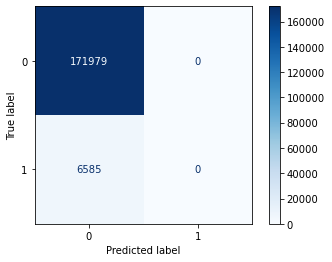

In [53]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [54]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

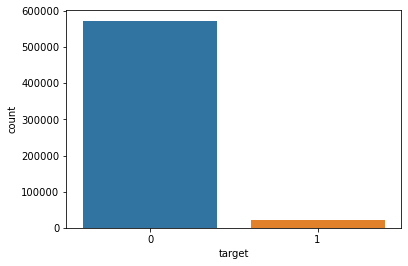

In [55]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [56]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

*''Я нашел поистине удивительное доказательство этого факта, однако ширина полей не позволяет его здесь привести.''* (c)

AUC - area under curve.  
Здесь не очень понятно, о какой кривой (curve) идет речь. Существует формула

**Gini_norm = 2 * ROC AUC - 1**

Ее вывод весьма сложен и мало где приводится. Один из выводов этой формулы существует в статье:  
[Коэффициент Джини. Из экономики в машинное обучение (https://habr.com/ru/company/ods/blog/350440/)](https://habr.com/ru/company/ods/blog/350440/)  
Он состоит из нескольких страниц зубодробительных формул. Нет смысла его здесь повторять.

С другой стороны под AUC в этом задании может пониматься площадь под самой кривой Gini. Раасотрим далее этот случай.

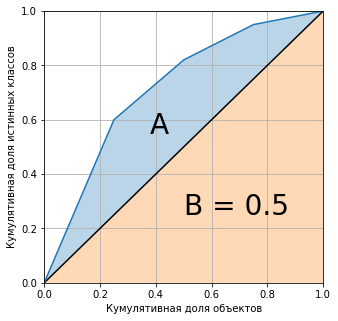

In [57]:
x = [0, 0.25, 0.5, 0.75, 1]
equality_line = x
gini_curve = [0, 0.6, 0.82, 0.95, 1]
plt.figure(figsize=[5,5])
plt.plot(x, equality_line, color = 'black')
plt.plot(x, gini_curve)
plt.fill_between(x, equality_line, gini_curve, alpha=0.3)
plt.fill_between(x, 0, equality_line, alpha=0.3)
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.text(0.38,0.55,'A',fontsize = 28)
plt.text(0.5,0.25,'B = 0.5',fontsize = 28)
plt.xlabel('Кумулятивная доля объектов')
plt.ylabel('Кумулятивная доля истинных классов')
plt.show()

Коэффициент Джини есть отношение площади фигуры, образованной кривой Лоренца (голубая кривая на рисунке) и прямой равенства (черная линия), к площади треугольника, образованного прямой равенства и осями.

**G = A / B = A / 0.5 = 2A**

AUC есть площади фигуры, образованной кривой Лоренца и осями.

**AUC = A + B**

Тогда 

**2 * AUC - 1 = 2 * (A + B) - 1 = 2 * (A + 0.5) - 1 = 2A**

Следовательно

**G = 2 * AUC - 1**

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Метрики для несбалансированных классов хорошо описаны в статье:  
[Tour of Evaluation Metrics for Imbalanced Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)  

Для применения предлагаются следующие метрики:

**Threshold Metrics**
- The confusion matrix
- Sensitivity-Specificity, G-Mean (широко применяется в медицине при тестировании)
- Precision-Recall, F-Measure

**Ranking Metrics**
- ROC AUC

**Probability Metrics**
- LogLoss
- BrierScore

Let's calculate the Normalized Gini Coefficient:

In [58]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [59]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [60]:
## your code

### Baseline - LogisticRegression

Создадим базовую модель, без какой-либо обработки

In [61]:
%%time
lr_pipe = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', LogisticRegression(max_iter=500))]
).fit(X_train, y_train);

Wall time: 32 s


In [62]:
y_pred = lr_pipe.predict_proba(X_valid)[:, 1]
gini_normalized(y_valid, y_pred)

0.26057103357893663

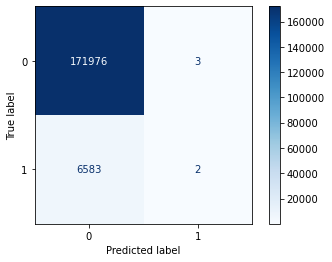

In [63]:
disp = plot_confusion_matrix(lr_pipe, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Результат практически такой же, как для SGDClassifier.

Читаем тестовый датасет, делаем предсказание и загружаем на Kaggle.

In [64]:
insurance_test_data = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

In [65]:
y_pred = lr_pipe.predict_proba(insurance_test_data)[:, 1]

In [66]:
output = pd.DataFrame({'id': insurance_test_data.index, 'target': y_pred})
output.to_csv('porto_lr_subm.csv', index=False)

Kaggle Private Score - 0.26437

# Work in progress

### Undersampling

In [67]:
X_sampled_0, y_sampled_0 = resample(X[y==0], y[y==0], n_samples=(y == 1).sum())
X_sampled = pd.concat([X_sampled_0, X[y==1]])
y_sampled = pd.concat([y_sampled_0, y[y==1]])
del X_sampled_0, y_sampled_0
y_sampled.value_counts()

0    21694
1    21694
Name: target, dtype: int64

### EDA

In [68]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
categorical_features = [column for column in X if (column.endswith("cat"))]
binary_features = [column for column in X if (column.endswith("bin"))]

### Feature Engineering